In [1]:
import math as ma
import numpy as np
import pylab as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import pandas as pd
from scipy.integrate import odeint

In [2]:
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res
    
def stoc_eqs(INP,beta,gamma,N,nreacciones,tau): 
    V = INP
    Rate=np.zeros((nreacciones))
    Change=np.zeros((nreacciones,len(V)))
    N=V[0]+V[1]+V[2]
    Rate[0] = beta*V[0]*V[1]/N; Change[0,:]=([-1, +1, 0])
    Rate[1] = gamma*V[1];  Change[1,:]=([0, -1, +1])
    for i in range(nreacciones):
        K_i=np.random.poisson(Rate[i]*tau)
        K_i=min([K_i, V[find(Change[i,:]<0)]])
        V=V+Change[i,:]*K_i
    return V

def Stoch_Iteration(INPUT,beta,gamma,N,nreacciones,T,tau):
    lop=0
    S=[]
    I=[]
    R=[]
    SI=[]
    for lop in T:
        res = stoc_eqs(INPUT,beta,gamma,N,nreacciones,tau)
        S.append(INPUT[0])
        I.append(INPUT[1])
        R.append(INPUT[2])
        if INPUT[1]==0:
            break
        INPUT=res
    return S,I,R
def one_trajectory(S0,I0,R0,beta,gamma,N,nreacciones,Tmax,tau):
    INPUT = np.array((S0,I0,R0))
    T=np.arange(0.0, Tmax, tau)
    [S,I,R]=Stoch_Iteration(INPUT,beta,gamma,N,nreacciones,T,tau)
    return R[-1]

def R_inf_dist(nsims,S0,I0,R0,beta,gamma,popsize,nreacciones,Tmax,tau):
    T=np.arange(0.0, Tmax, tau)
    matrs=[0.0 for i in range(popsize+1)]
    n=[]
    for l in range(nsims):
        Ri=one_trajectory(S0,I0,R0,beta,gamma,popsize,nreacciones,Tmax,tau)
        matrs[int(Ri)]+=1
        n.append(Ri)
        #if l%500==0:
        #    print(l)
    return n

In [11]:
nsims=2000
I0=2
R0=0
N=100000
S0=N-I0
beta=2.0
gamma=1.0
nreacciones=2
Tmax=200
tau=0.05

In [ ]:
a=R_inf_dist(nsims,S0,I0,R0,beta,gamma,N,nreacciones,Tmax,tau)

In [4]:
def umbral_AR(umbral,AR):
    ARsn=[n for n in AR if n<umbral]
    return len(ARsn)/len(AR)


In [ ]:

betas=[0.5+0.1*i for i in range(30)]
I0s = [1,2,4]
rets=[]

for i in range(len(betas)):
    aux=R_inf_dist(nsims,S0,I0,R0,betas[i],gamma,N,nreacciones,Tmax,tau)
    aux_u=umbral_AR(0.05*N+I0,aux)
    print(i)
    rets.append(aux_u)

In [ ]:
plt.scatter(betas,rets,c="darkred",s=10, label="Simulations")
ret_T=[1 if betas[i]<1 else (1/betas[i])**I0 for i in range(len(betas))]
plt.plot(betas,ret_T,color="black",lw=1,label="Whittle (1955)")
plt.xlabel(r"$\mathcal{R}_0$")
plt.ylabel("Probability of no outbreak")
plt.title("$I_0=2$")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
betas=[0.5+0.1*i for i in range(30)]
I0s = [1,2,4,8]
PNOs=[]
for j in range(len(I0s)):
    ret_s=[]
    print(I0s[j])
    for i in range(len(betas)):
        aux=R_inf_dist(nsims,S0,I0s[j],R0,betas[i],gamma,N,nreacciones,Tmax,tau)
        aux_u=umbral_AR(0.05*N+I0s[j],aux)
        print(i)
        ret_s.append(aux_u)
    PNOs.append(ret_s)


In [ ]:
clist=["darkred","coral","olive","cadetblue"]
for i in range(4):
    plt.scatter(betas,PNOs[i],c=clist[i],label="$I_0=$"+str(I0s[i]))
    ret_aux=[1 if betas[k]<1 else (1/betas[k])**I0s[i] for k in range(len(betas))]
    if i==0:
        plt.plot(betas,ret_aux,"--",c="black",label="Whittle (1955)")
    plt.plot(betas,ret_aux,"--",c=clist[i])

plt.xlabel(r"$\mathcal{R}_0$")
plt.ylabel("Probability of no outbreak")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

# Treshold guided by deterministic final size instead of population

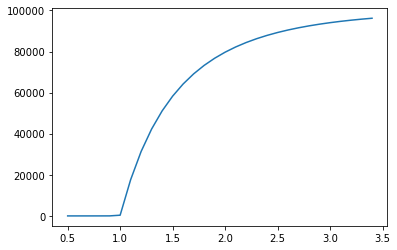

In [12]:

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I 
    return dSdt, dIdt, dRdt
def detRinf(I0,t,N,beta,gamma):
    y0=N-I0, I0,0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    return R[-1]
T=np.arange(0.0, Tmax, tau)
vvec=[]
betas=[0.5+0.1*i for i in range(30)]
for i in range(len(betas)):
    erre0=betas[i]/gamma
    vvec.append(detRinf(I0,T,N,betas[i],gamma))

plt.plot(betas,vvec)

In [17]:
betas=[0.5+0.1*i for i in range(30)]
I0s = [1,2,4,8]
PNOs=[]
N=100000
for j in range(len(I0s)):
    ret_s=[]
    print(I0s[j])
    for i in range(len(betas)):
        umbral_FS=detRinf(I0,T,N,betas[i],gamma)
        aux=R_inf_dist(2000,S0,I0s[j],R0,betas[i],gamma,N,nreacciones,Tmax,tau)
        aux_u=umbral_AR(0.05*N+2*I0s[j],aux)
        #print(i)
        ret_s.append(aux_u)
    PNOs.append(ret_s)


1
2
4
8


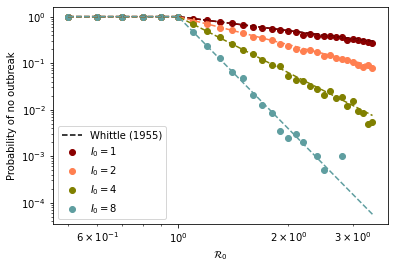

In [18]:
clist=["darkred","coral","olive","cadetblue"]
for i in range(4):
    plt.scatter(betas,PNOs[i],c=clist[i],label="$I_0=$"+str(I0s[i]))
    ret_aux=[1 if betas[k]<1 else (1/betas[k])**I0s[i] for k in range(len(betas))]
    if i==0:
        plt.plot(betas,ret_aux,"--",c="black",label="Whittle (1955)")
    plt.plot(betas,ret_aux,"--",c=clist[i])

plt.xlabel(r"$\mathcal{R}_0$")
plt.ylabel("Probability of no outbreak")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

In [2]:
27000+567000+221000

815000